In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv('../all_stocks_5yr.csv')
df.head(100)

FileNotFoundError: [Errno 2] No such file or directory: '../all_stocks_5yr.csv'

Data Exploration

In [ ]:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [ ]:
df['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

Data Cleaning and Pre-Processing

In [ ]:
# Dropping the Null columns
df.dropna(inplace=True)

# Changing the Date format from object to Datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   Name    619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


In [ ]:
# Calculating the average trade of all stocks in the dataset and sorting it in order to get the Top 10 which will be used for further analysis
data_dict = {}
print("Unique count for ticker column : " , df['Name'].nunique())
print()
for ticker in df['Name'].unique():
    avg = df[df['Name'] == ticker]['volume'].mean()
    data_dict[ticker] = avg
print("All stocks with respective avegrae trade volumes : " ,  data_dict)

sorted_items = sorted(data_dict.items(), key=lambda item: item[1], reverse=True)[:10]
top_10 = {item[0]: item[1] for item in sorted_items}
print()
print("Top 10 stocks with highest trade volume : " , top_10.keys())

Unique count for ticker column :  505

All stocks with respective avegrae trade volumes :  {'AAL': 9390321.324066719, 'AAPL': 54047899.73550437, 'AAP': 1078043.216838761, 'ABBV': 7870682.665607625, 'ABC': 2005738.3232724385, 'ABT': 6964036.691818904, 'ACN': 2596238.098490866, 'ADBE': 2998133.5996822873, 'ADI': 2451738.088959492, 'ADM': 3647857.6870532166, 'ADP': 2022774.221604448, 'ADSK': 2482750.679110405, 'ADS': 619308.5424940429, 'AEE': 1622724.4956314536, 'AEP': 2781243.0254169977, 'AES': 5568655.816521049, 'AET': 2716448.100873709, 'AFL': 2116351.5226370133, 'AGN': 2880076.8125496428, 'AIG': 8419467.383637808, 'AIV': 1198721.3010325655, 'AIZ': 545139.3129467831, 'AJG': 924431.0667196187, 'AKAM': 2182469.447180302, 'ALB': 1160881.819698173, 'ALGN': 885551.828435266, 'ALK': 1537615.6846703733, 'ALLE': 739724.4948259642, 'ALL': 2407102.868149325, 'ALXN': 1762434.8204924543, 'AMAT': 13230027.8649722, 'AMD': 32519037.79666402, 'AME': 1308148.1326449562, 'AMGN': 3465404.566322478, 'AMG'

In [ ]:
top_10_stocks = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']
filtered_df = df[df['Name'].isin(top_10_stocks)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
...,...,...,...,...,...,...,...
12585,2018-02-01,43.0400,44.0900,42.1000,42.4900,35713522,MU
12586,2018-02-02,42.0000,42.2100,40.6100,40.8200,40657381,MU
12587,2018-02-05,40.1400,41.5300,39.0100,39.4000,45796837,MU
12588,2018-02-06,40.5500,43.9300,40.5500,43.8800,66972802,MU


In [ ]:
def plot(data, stock_name, price_type):
    data_subset = data[data['Name'] == stock_name ]
    data_subset.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(16,8))
    plt.plot(data_subset[price_type])
    plt.title(f" {price_type} Price Visualization for {stock_name}")
    plt.xlabel('Days')
    plt.ylabel(f'{price_type} Price Value in USD ')
    plt.show()

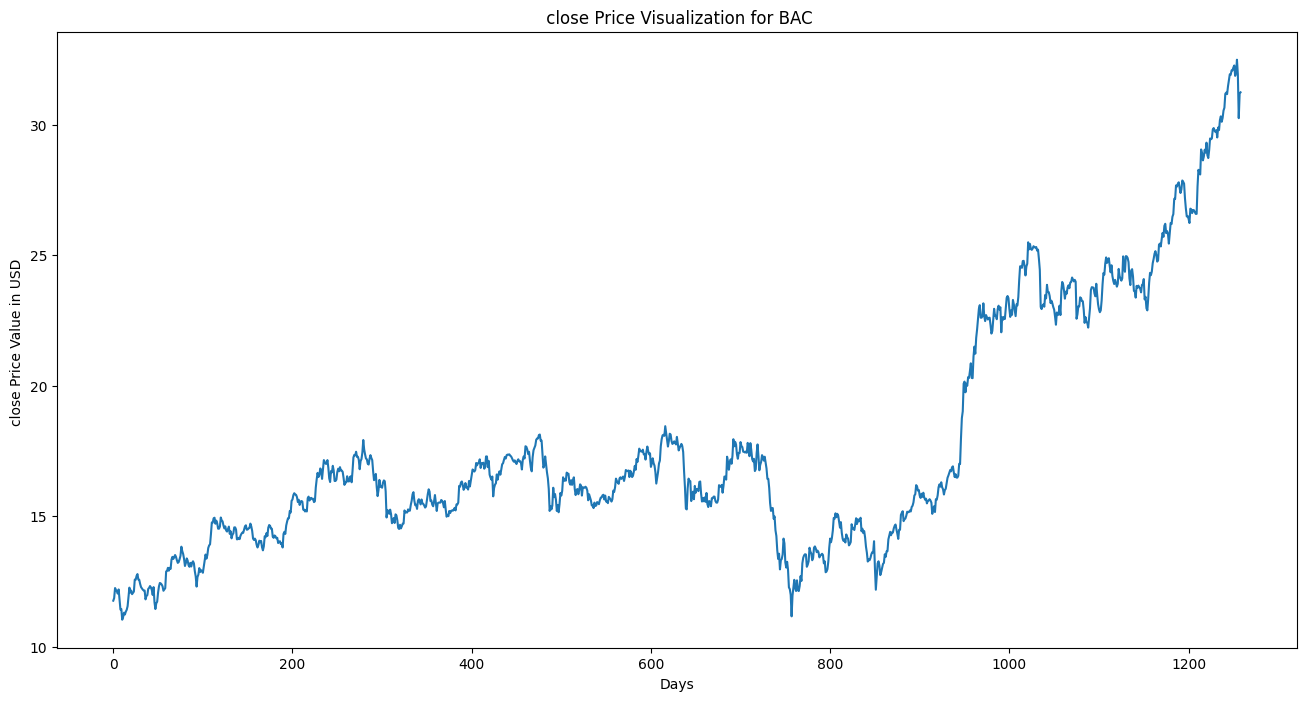

In [ ]:
plot(filtered_df, 'BAC', 'close')

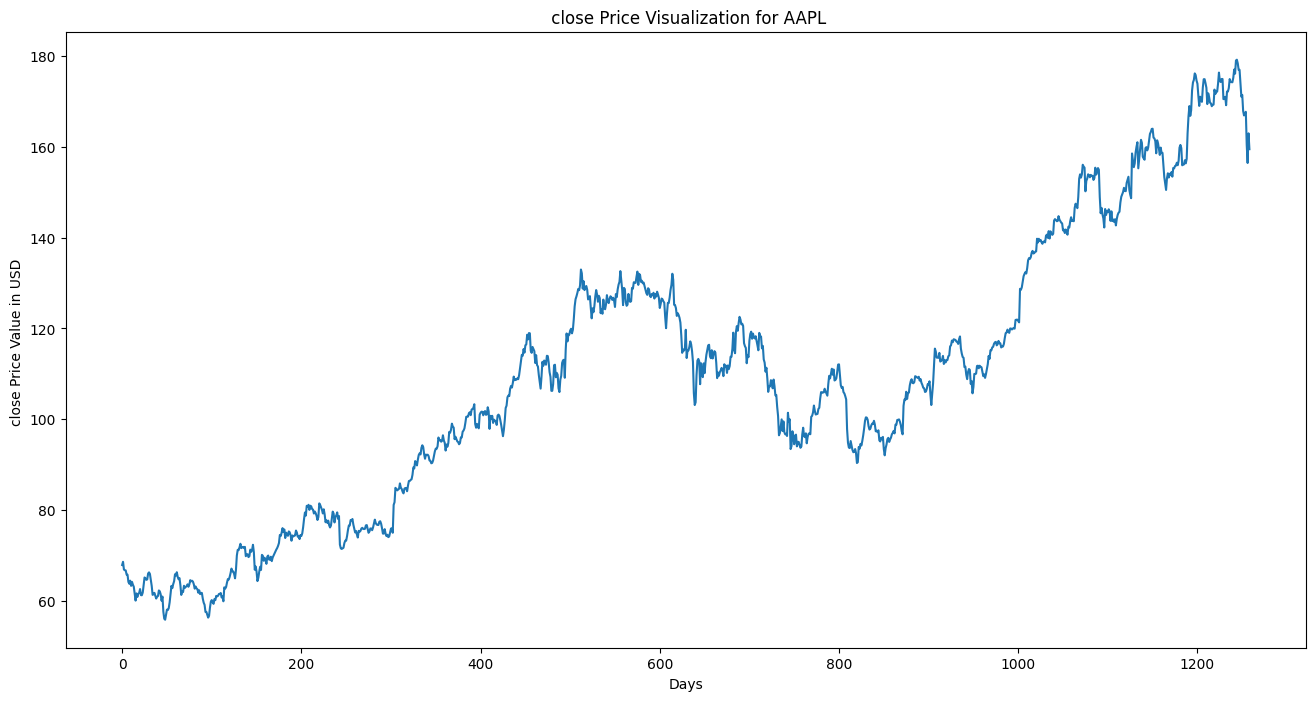

In [ ]:
plot(filtered_df, 'AAPL', 'close')

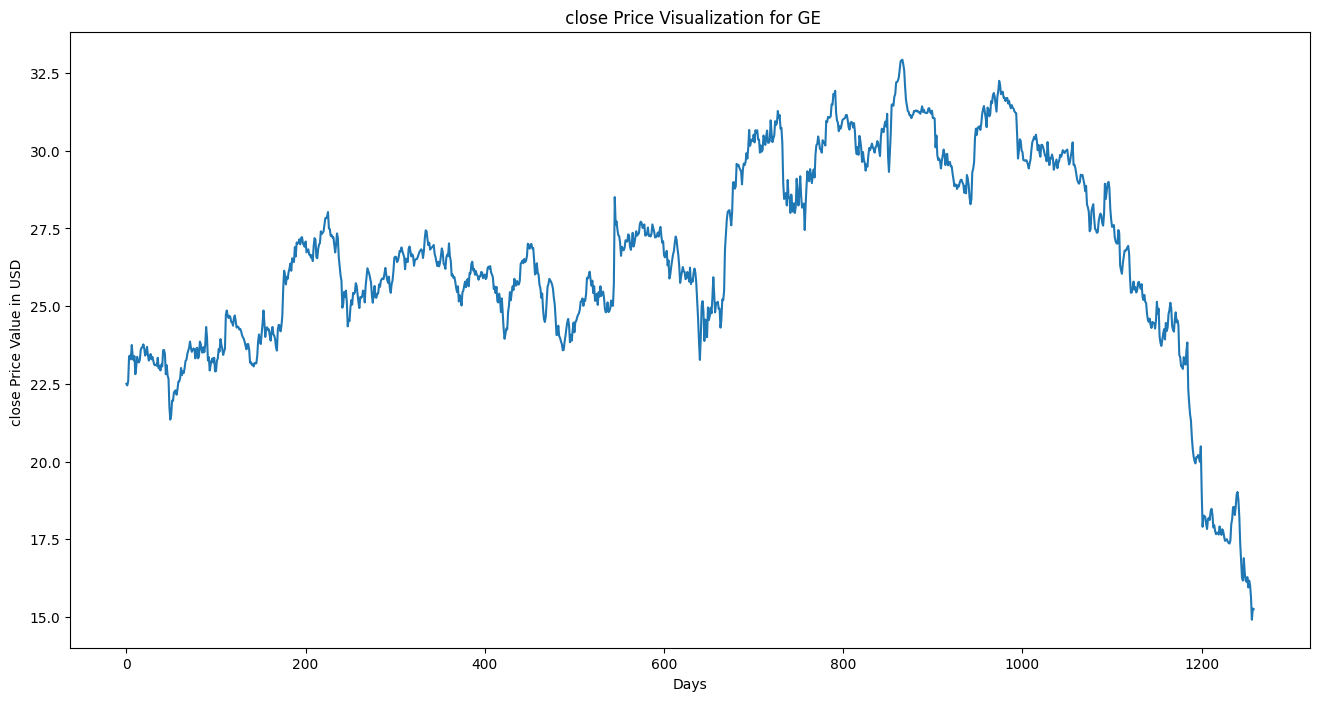

In [ ]:
plot(filtered_df, 'GE', 'close')

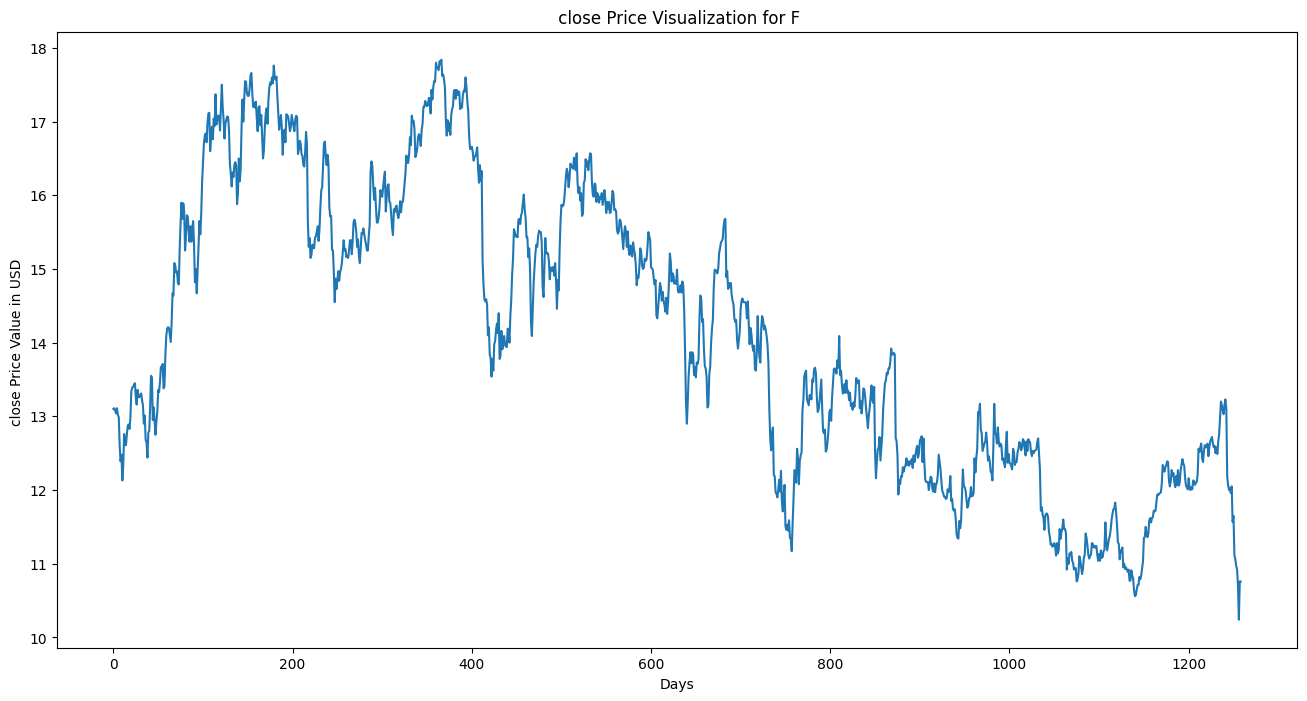

In [ ]:
plot(filtered_df, 'F', 'close')

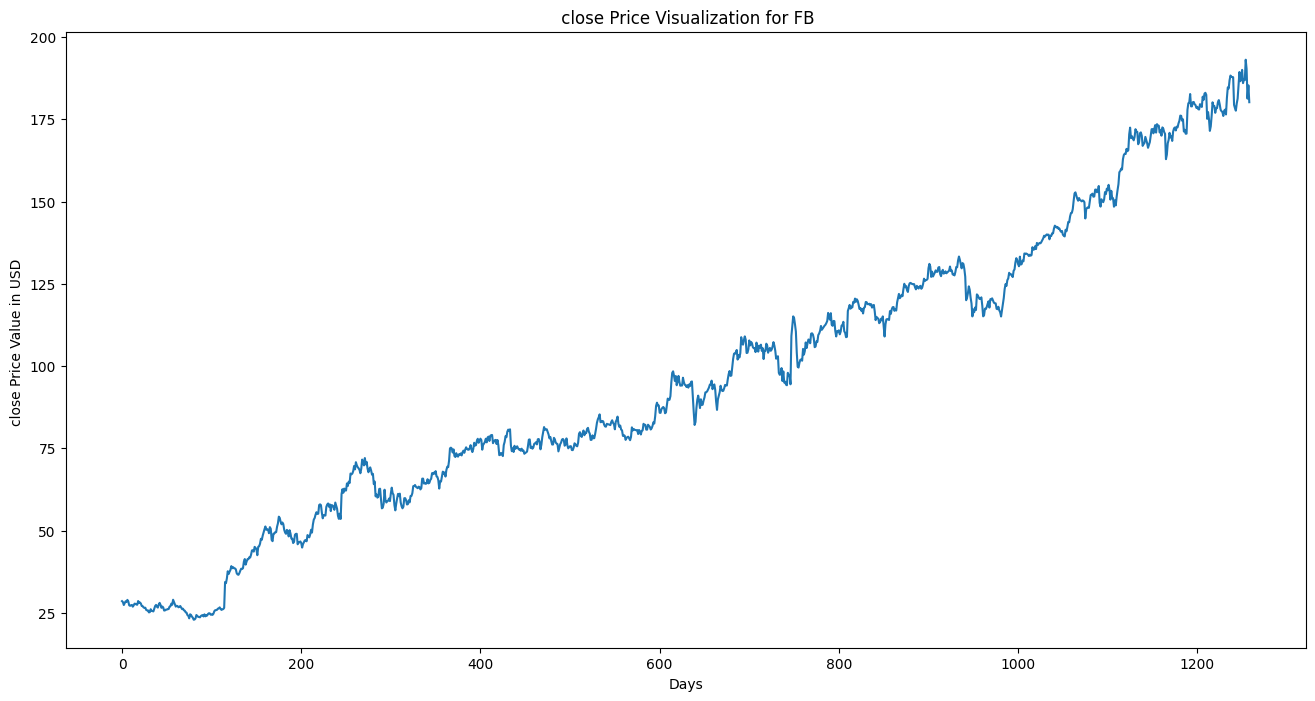

In [ ]:
plot(filtered_df, 'FB', 'close')

Exploratory Data Analysis

In [ ]:
def stock_basic_statistics(data, stocks):
    stock_stats = {}
    
    for stock in stocks:
        stock_data = data[data['Name'] == stock]
        closing_price = stock_data['close']
        opening_price = stock_data['open']
        highest_rate = stock_data['high'].max()
        lowest_rate = stock_data['low'].min()

        stock_stats[stock] = {
            'Closing Price': closing_price.mean(),
            'Opening Price': opening_price.mean(),
            'Highest Rate': highest_rate,
            'Lowest Rate': lowest_rate
        }

    return pd.DataFrame.from_dict(stock_stats, orient='index')
stock_stats = stock_basic_statistics(filtered_df, top_10_stocks)
print(stock_stats)

      Closing Price  Opening Price  Highest Rate  Lowest Rate
BAC       17.704178      17.706624         32.67      10.9800
AAPL     109.066698     109.055429        180.10      55.0142
GE        26.526342      26.529190         33.00      14.7100
F         14.102637      14.112669         18.12      10.1900
FB        96.478610      96.455059        195.32      22.6700
MSFT      51.063081      51.026394         96.07      27.2300
AMD        5.601863       5.604315         15.65       1.6100
MU        22.972593      22.985880         49.89       7.6400
INTC      31.831531      31.804532         50.85      20.1000
CSCO      27.743813      27.725160         42.98      19.9800


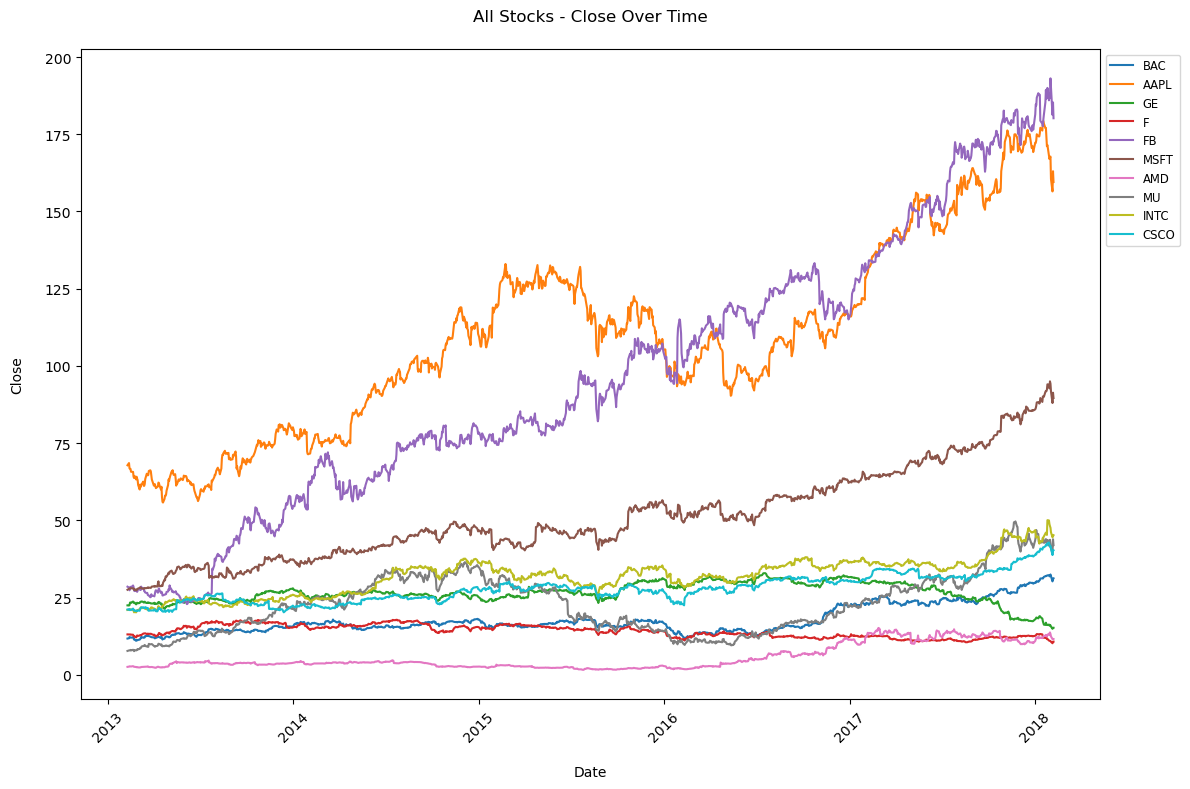

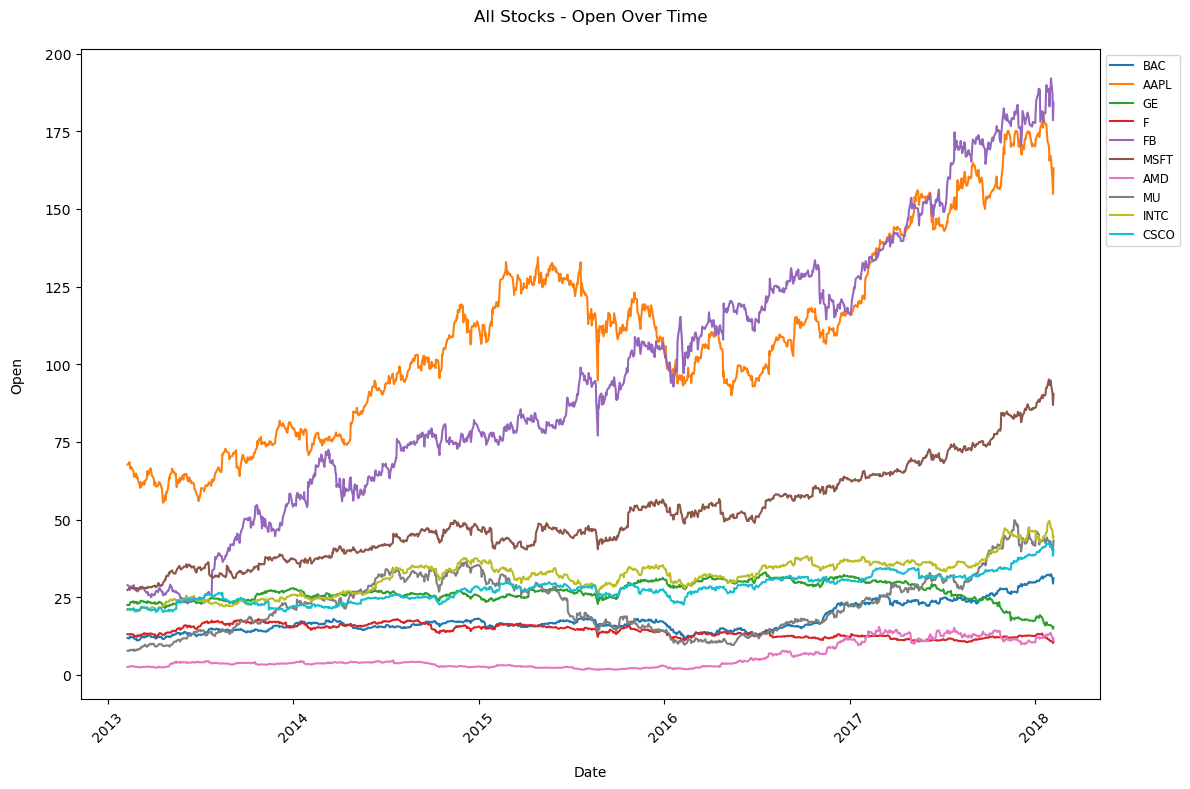

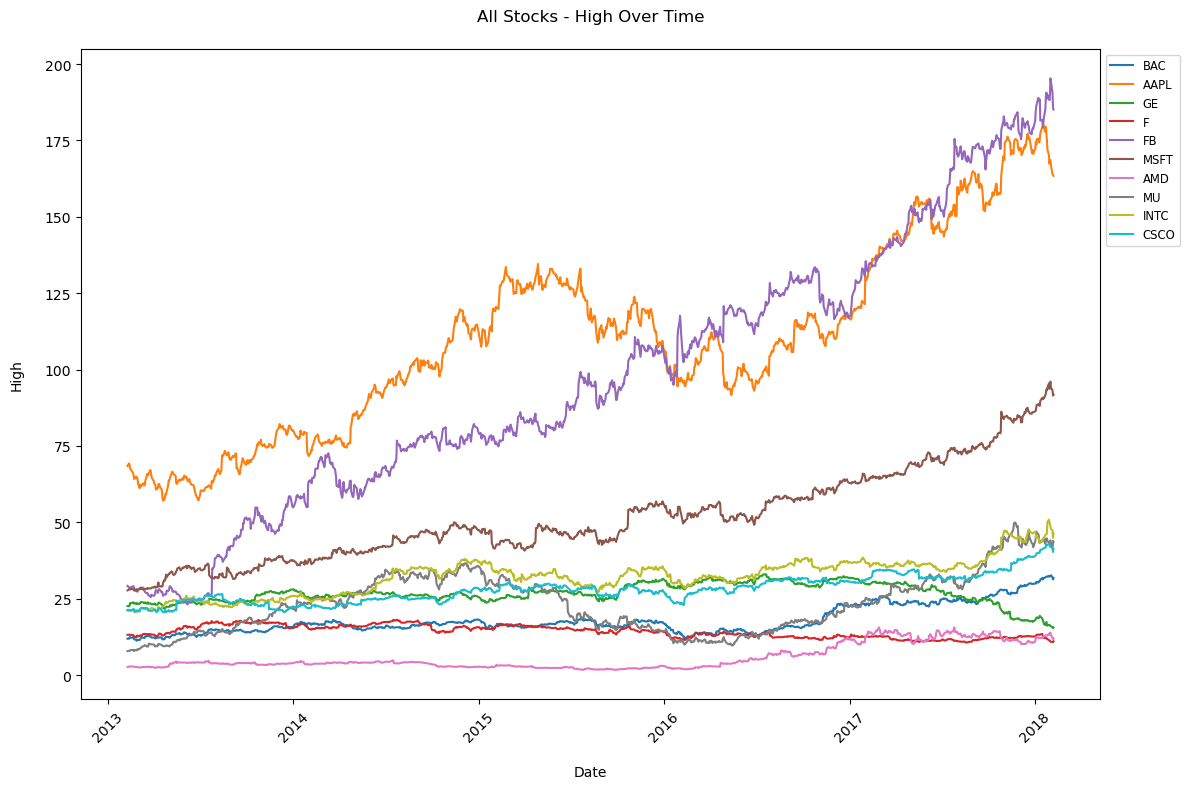

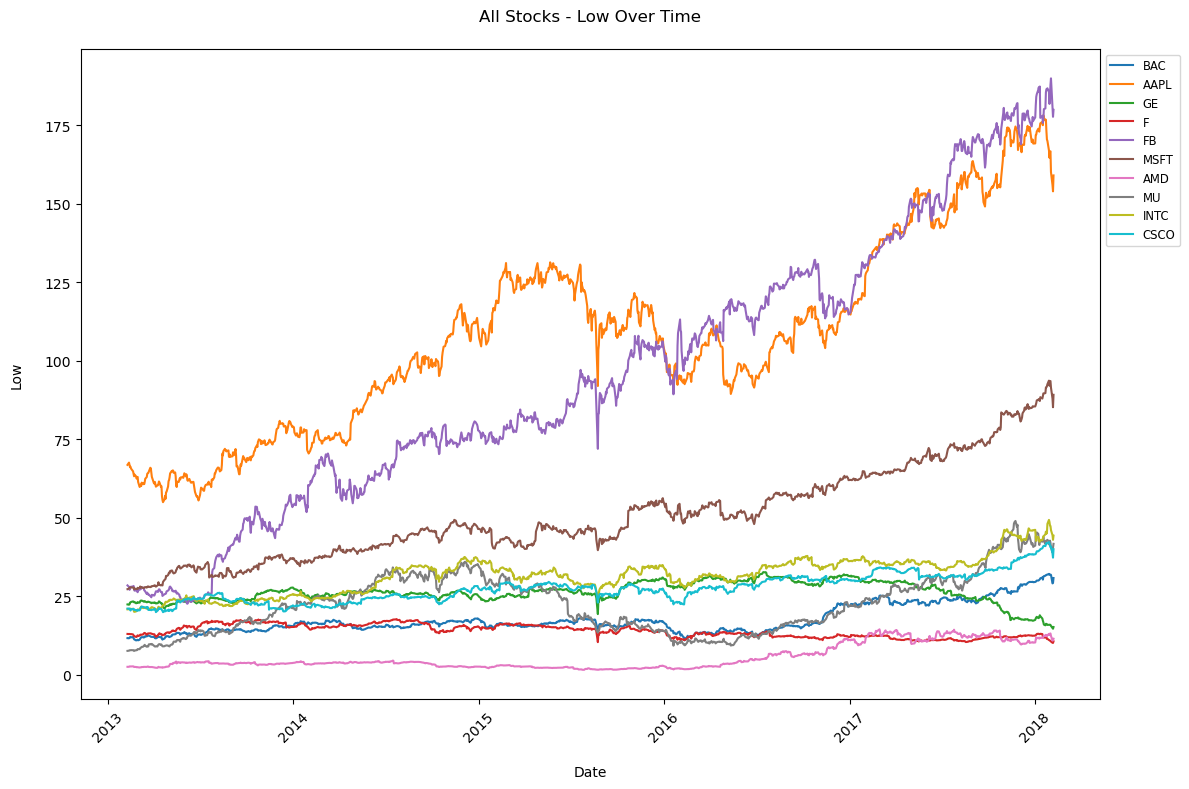

In [ ]:
def visualize_all_stocks_prices(data, price_type):
    plt.figure(figsize=(12, 8))

    for stock in top_10_stocks:
        stock_data = data[data['Name'] == stock]
        plt.plot(stock_data['date'], stock_data[price_type], label=stock)

    plt.title(f'All Stocks - {price_type.capitalize()} Over Time', pad=20)
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(price_type.capitalize(), labelpad=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize Prices Over Time for All Stocks
price_types = ['close', 'open', 'high', 'low']
for price_type in price_types:
    visualize_all_stocks_prices(filtered_df, price_type)

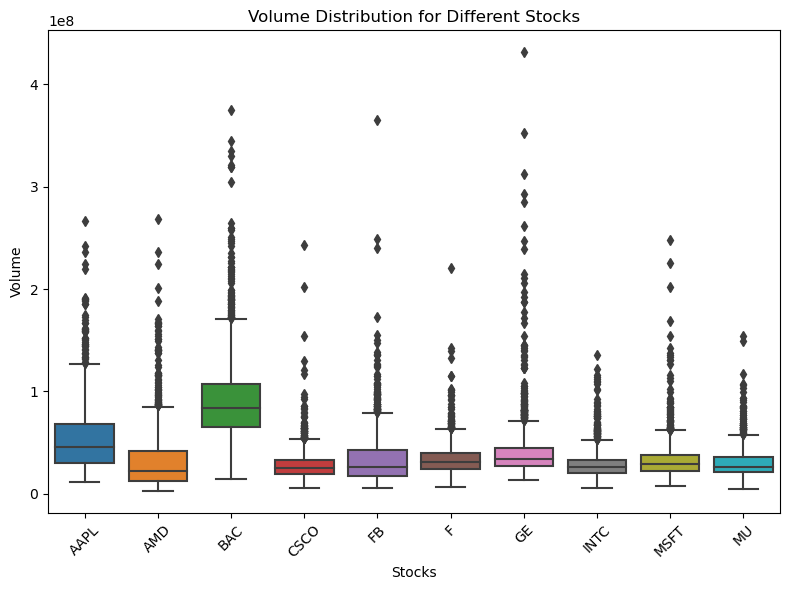

In [ ]:
# Box plot for volume to identify outliers
plt.figure(figsize=(8, 6))
snd.boxplot(data=filtered_df, x='Name', y='volume')
plt.title('Volume Distribution for Different Stocks')
plt.xlabel('Stocks')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


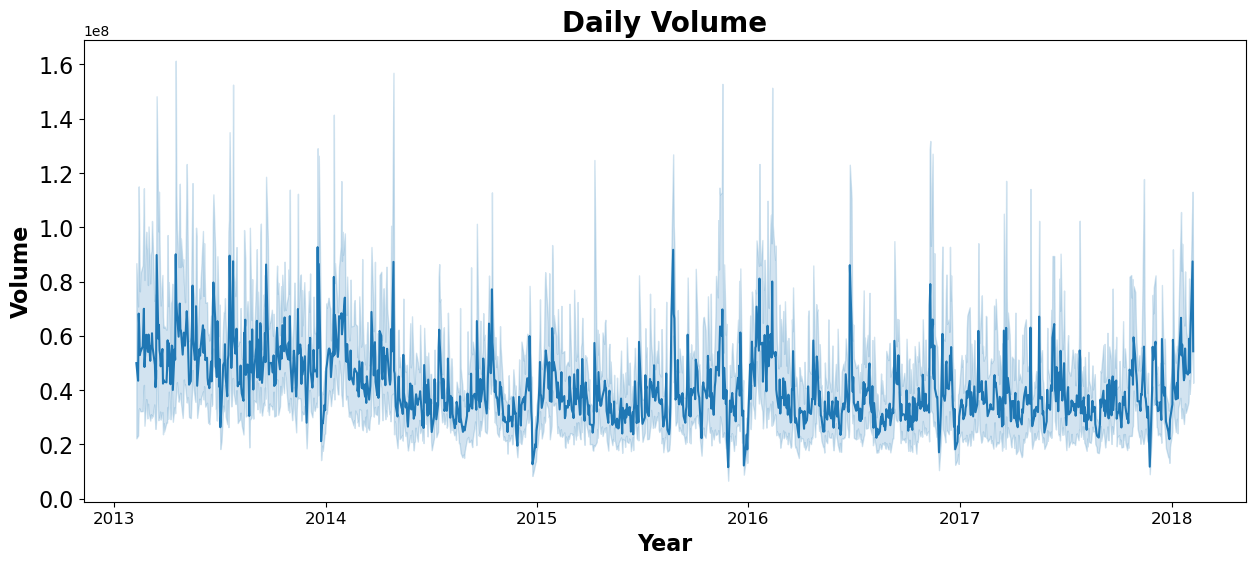

In [ ]:
# Convert 'Date' column to datetime because it's not already in datetime format
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
snd.lineplot(data=filtered_df, x='date', y='volume')

# Formatting
ax.set_title('Daily Volume', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Volume', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=12)  # Adjusting X-axis label size if needed
plt.show()


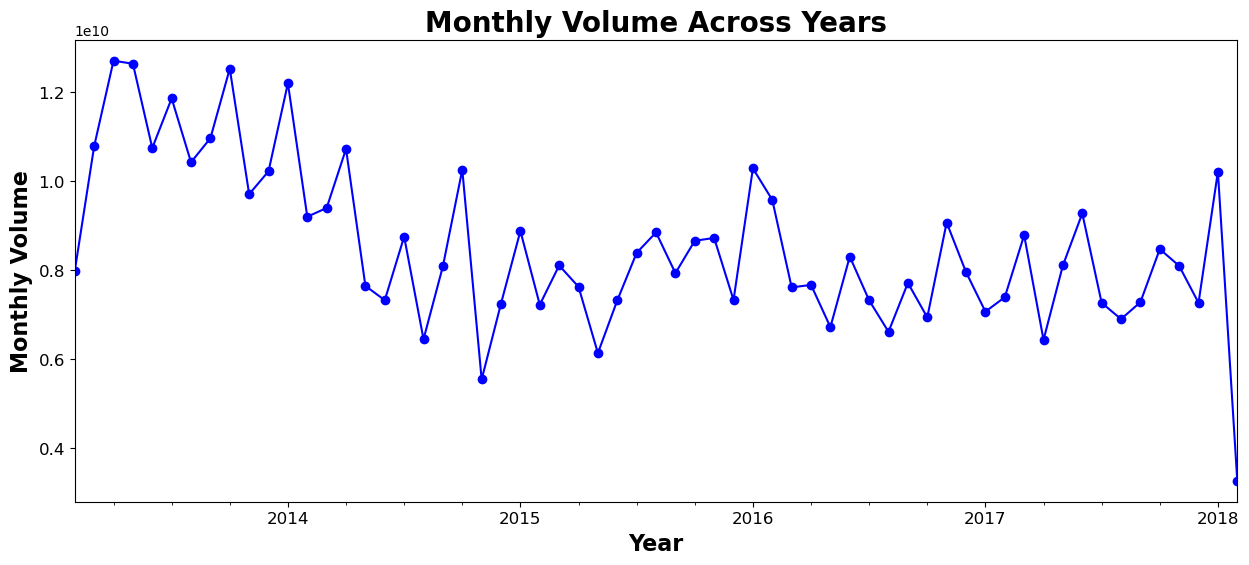

In [ ]:
# New DataFrame to hold the monthly volume data
monthly_volume_df = filtered_df.copy()

# Convert 'Date' column to datetime if it's not already in datetime format
monthly_volume_df['date'] = pd.to_datetime(monthly_volume_df['date'])

# Set 'Date' column as the DataFrame's index for monthly volume data
monthly_volume_df.set_index('date', inplace=True)

# Resample data to monthly frequency and calculate the sum of volume for each month
monthly_volume = monthly_volume_df.resample('M')['volume'].sum()

# Plot Monthly Volume against Year
fig, ax = plt.subplots(figsize=(15, 6))
monthly_volume.plot(ax=ax, color='blue', marker='o')

# Formatting
ax.set_title('Monthly Volume Across Years', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Monthly Volume', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=12)  # Adjust Y-axis label size if needed
plt.tick_params(axis='x', which='major', labelsize=12)  # Adjust X-axis label size if needed

plt.show()


SEASONALITY

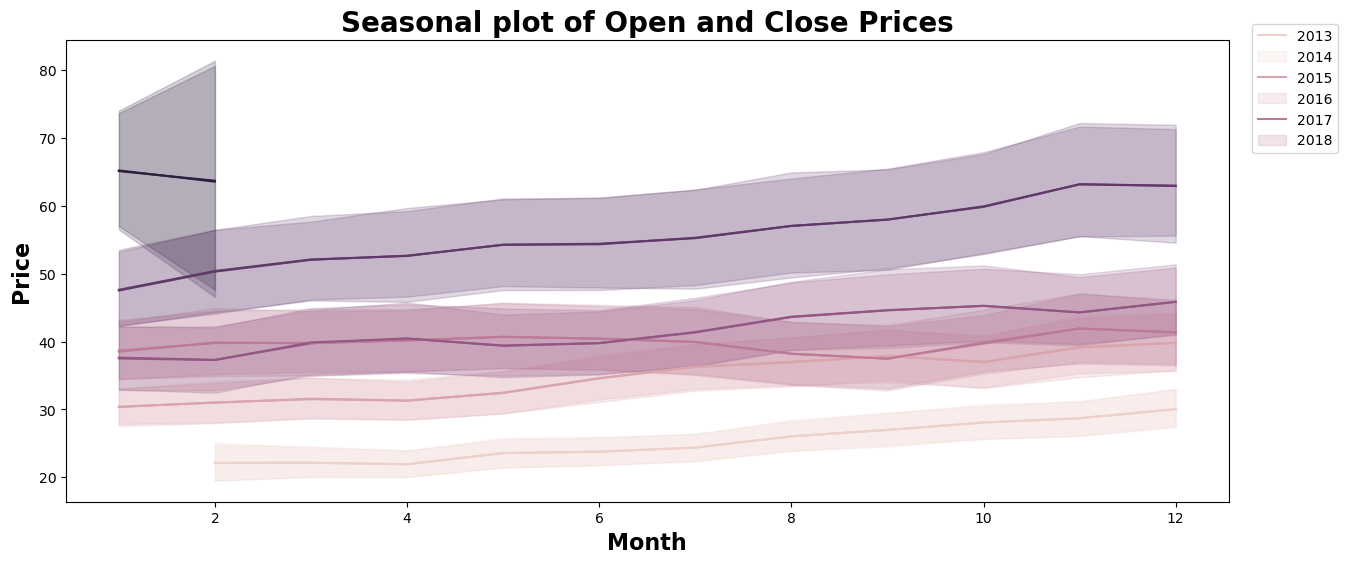

In [ ]:
# Set the variable to plot
variables = ['open', 'close']  # Assuming 'open' and 'close' are the column names for opening and closing prices

# Convert 'Date' column to datetime if it's not already in datetime format
filtered_df = filtered_df.copy()  # Create a copy to avoid warnings while modifying the original DataFrame
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Extract month and year information using .dt accessor with .loc to set values
filtered_df.loc[:, 'Month'] = filtered_df['date'].dt.month
filtered_df.loc[:, 'Year'] = filtered_df['date'].dt.year

# Create a figure for the seasonal line plot for both 'Open' and 'Close' prices
plt.figure(figsize=(15, 6))

# Plot the seasonal line plot for both 'Open' and 'Close' prices
for variable in variables:
    snd.lineplot(data=filtered_df, x='Month', y=variable, hue='Year')

# Format the plot
plt.title('Seasonal plot of Open and Close Prices', fontsize=20, loc='center', fontweight='bold')
plt.xlabel('Month', fontsize=16, fontweight='bold')
plt.ylabel('Price', fontsize=16, fontweight='bold')
plt.legend(labels=[str(year) for year in filtered_df['Year'].unique()], bbox_to_anchor=(1.1, 1.05))

plt.show()


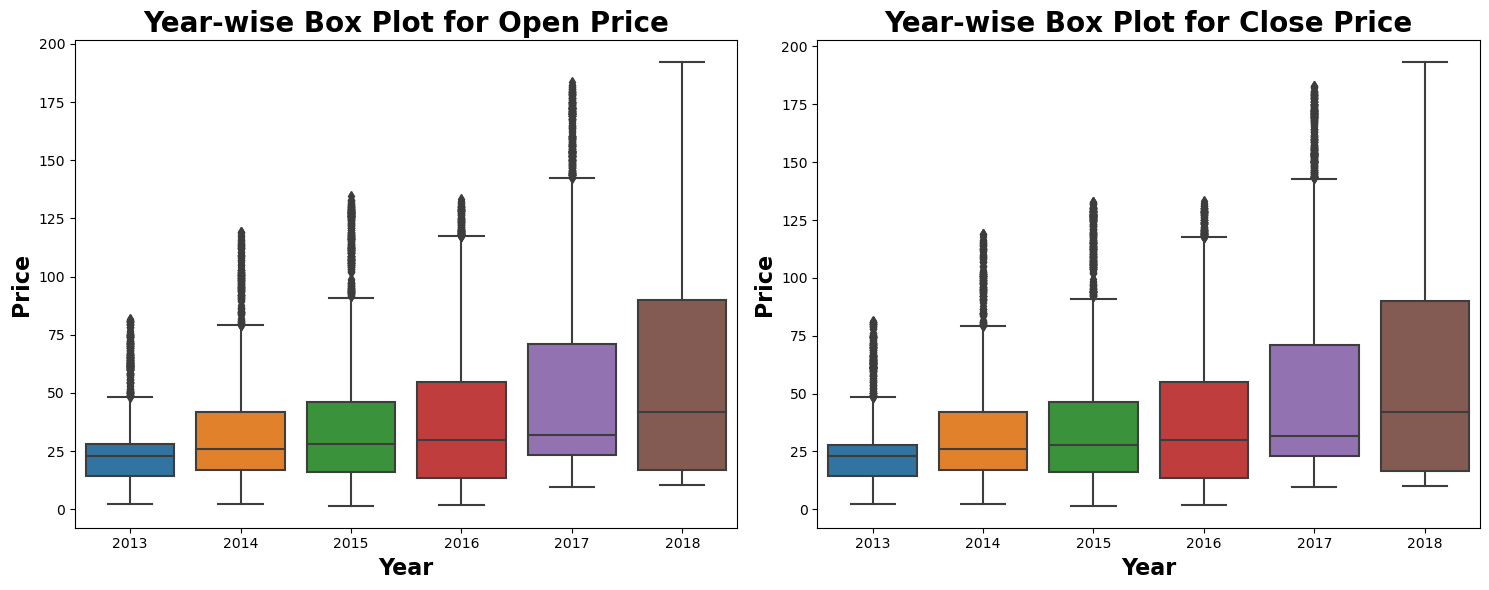

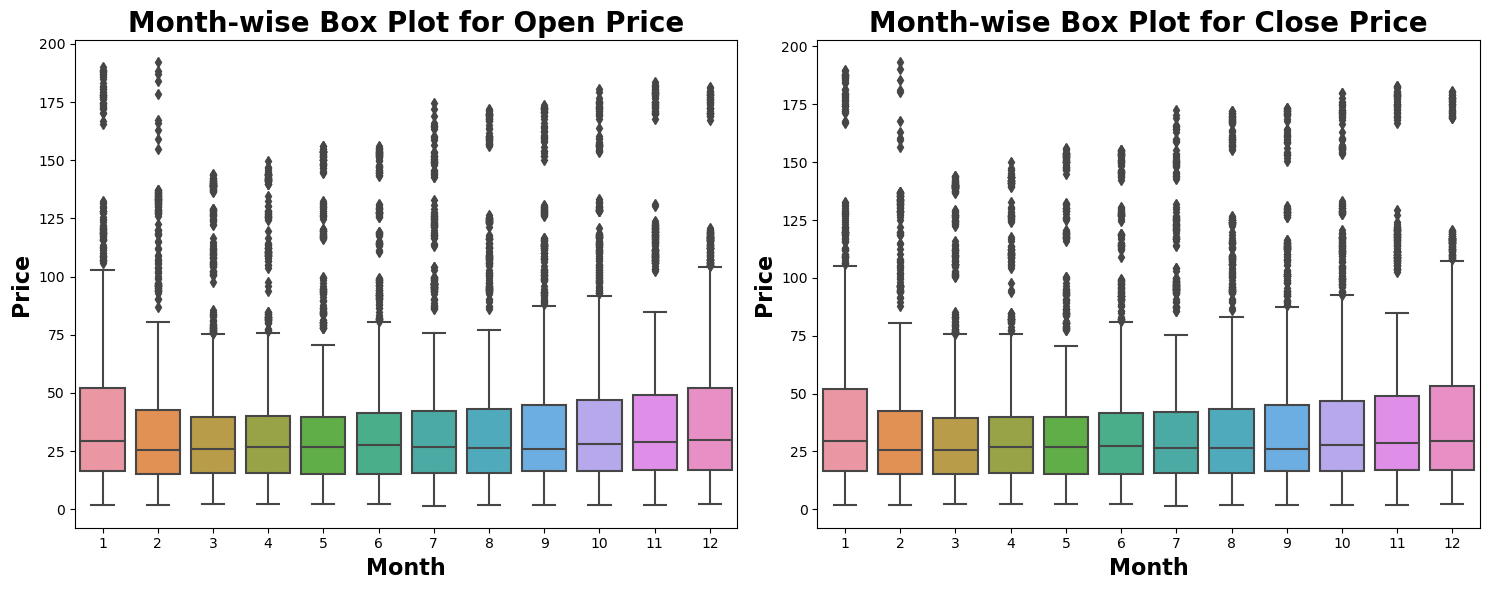

In [ ]:
# Create a separate figure for the year-wise box plot for both 'Open' and 'Close' prices
plt.figure(figsize=(15, 6))

# Plot the year-wise box plot for both 'Open' and 'Close' prices
for i, variable in enumerate(variables, 1):
    plt.subplot(1, 2, i)
    snd.boxplot(data=filtered_df, x='Year', y=variable)
    
    # Format the year-wise box plot
    plt.title(f'Year-wise Box Plot for {variable.capitalize()} Price', fontsize=20, loc='center', fontweight='bold')
    plt.xlabel('Year', fontsize=16, fontweight='bold')
    plt.ylabel('Price', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Create another separate figure for the month-wise box plot for both 'Open' and 'Close' prices
plt.figure(figsize=(15, 6))

# Plot the month-wise box plot for both 'Open' and 'Close' prices
for i, variable in enumerate(variables, 1):
    plt.subplot(1, 2, i)
    snd.boxplot(data=filtered_df, x='Month', y=variable)
    
    # Format the month-wise box plot
    plt.title(f'Month-wise Box Plot for {variable.capitalize()} Price', fontsize=20, loc='center', fontweight='bold')
    plt.xlabel('Month', fontsize=16, fontweight='bold')
    plt.ylabel('Price', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()



## Linear Regression Model

In [ ]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * np.dot(X.T, (model - y))
            db = (1/n_samples) * np.sum(model - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [ ]:
# Selecting Features and Target
X = df[['open', 'high', 'low', 'volume']].values
y = df['close'].values

# Normalizing Features
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1234)

In [ ]:
# Initializing and training the model
reg = LinearRegression(learning_rate=0.01, n_iterations=1000)
reg.fit(X_train, y_train)

# Predictions
predictions = reg.predict(X_test)

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [ ]:
# Evaluating the model
mse_value = mse(y_test, predictions)
print("MSE:", mse_value)

MSE: 1.1819324659296324


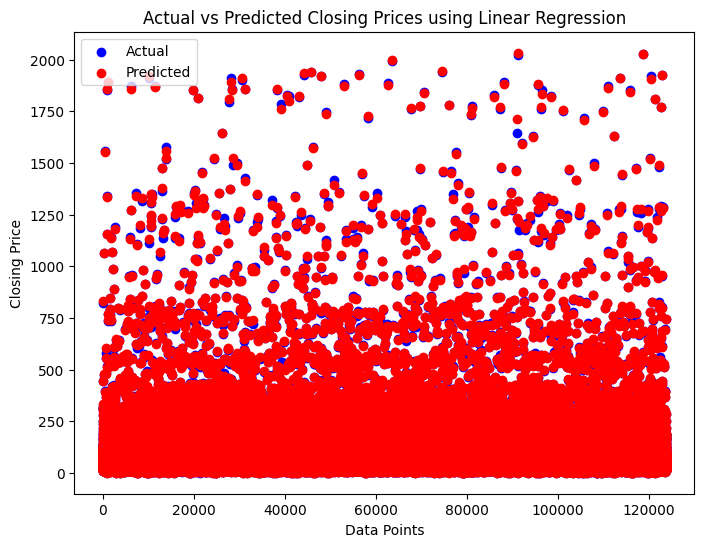

In [ ]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices using Linear Regression")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

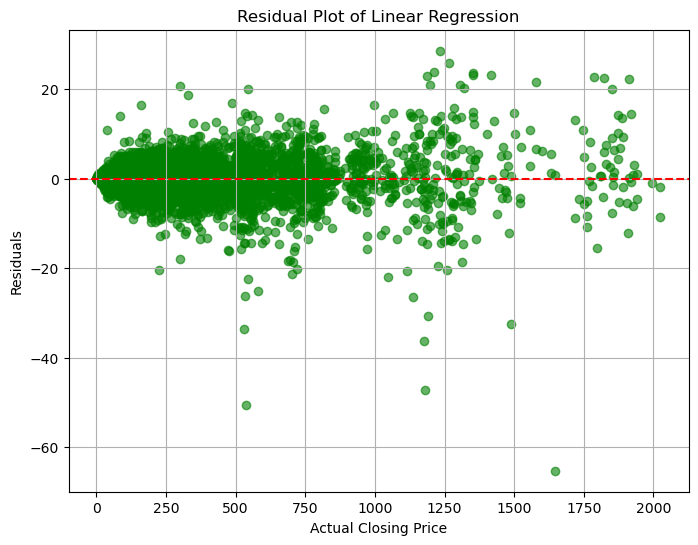

In [ ]:
residuals = y_test - predictions

plt.figure(figsize=(8, 6))

# Scatter plot of residuals
plt.scatter(y_test, residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  
plt.title("Residual Plot of Linear Regression")
plt.xlabel("Actual Closing Price")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


Linear Regression Coefficients: [ 3.24135989e+01  3.24843209e+01  3.24839023e+01 -6.44257526e-03]
Linear Regression Intercept: 83.03936920003873


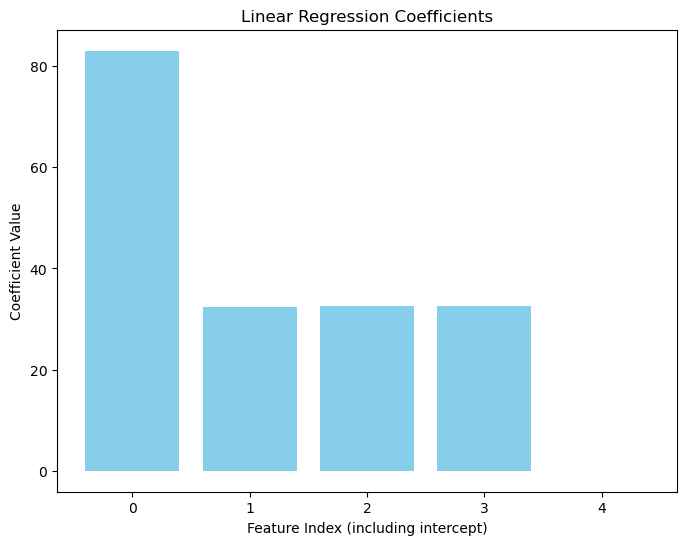

In [ ]:
# Assuming you have instantiated and trained your custom Linear Regression model
custom_reg = LinearRegression()
custom_reg.fit(X_train, y_train)

# Get coefficients and intercept
coefficients = custom_reg.weights
intercept = custom_reg.bias

# Print or use the coefficients
print("Linear Regression Coefficients:", coefficients)
print("Linear Regression Intercept:", intercept)

# Plotting the coefficients
n_features = len(coefficients)
plt.figure(figsize=(8, 6))
plt.bar(range(n_features + 1), np.concatenate(([intercept], coefficients)), color='skyblue')
plt.xlabel('Feature Index (including intercept)')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.show()


## Ridge Regression Model

In [ ]:
# Building and fitting the Ridge Regression Model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predicting the values
y_pred_ridge = ridge.predict(X_test)
print(y_pred_ridge)

[ 84.4932042   50.85742662  36.30422759 ... 286.05519289  54.26366393
  91.1635938 ]


In [ ]:
# Calculating metrics
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Mean Squared Error for Decision Tree Model: ", mse_ridge)
print("R-squared for Decision Tree Model: ", r2_ridge )

Ridge Regression Mean Squared Error for Decision Tree Model:  0.5055246212039454
R-squared for Decision Tree Model:  0.9999487823090492


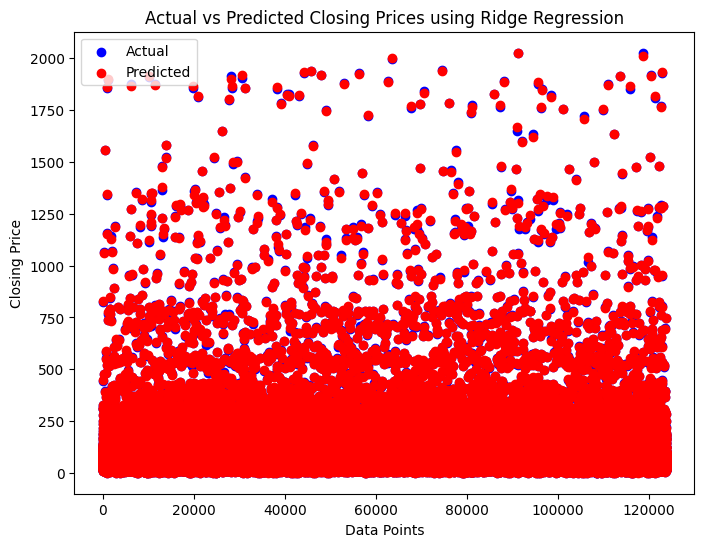

In [ ]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred_ridge)), y_pred_ridge, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices using Ridge Regression")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

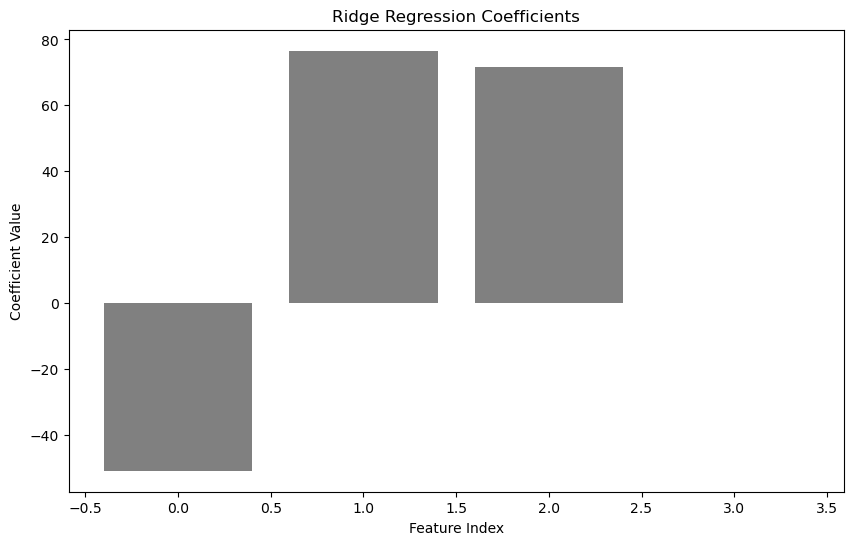

In [ ]:
# Fit Ridge Regression
ridge = Ridge(alpha=1.0)  # You can adjust alpha as needed
ridge.fit(X_train, y_train)

# Get coefficients from Ridge Regression
ridge_coefficients = ridge.coef_

# Plotting Ridge Regression coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(ridge_coefficients)), ridge_coefficients, color='grey')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')
plt.show()


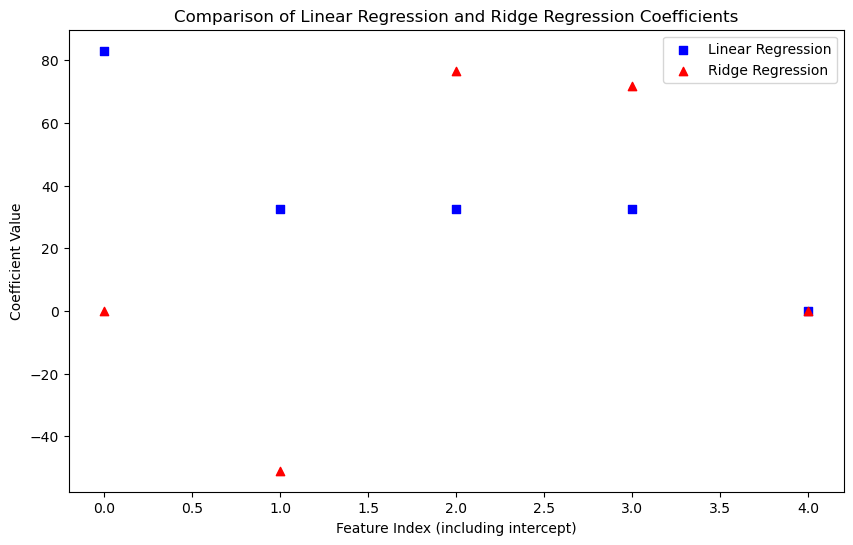

In [ ]:
# Fit Ridge Regression
ridge = Ridge(alpha=1.0)  # You can adjust alpha as needed
ridge.fit(X_train, y_train)

# Get coefficients from Ridge Regression
ridge_coefficients = ridge.coef_

# Assuming you have instantiated and trained your custom Linear Regression model
custom_reg = LinearRegression()
custom_reg.fit(X_train, y_train)

# Get coefficients for Linear Regression
linear_coefficients = custom_reg.weights
linear_intercept = custom_reg.bias

# Create indices for features (including the intercept)
n_features = len(linear_coefficients)
feature_indices = np.arange(n_features + 1)

# Scatter plot for Linear Regression coefficients
plt.figure(figsize=(10, 6))
plt.scatter(feature_indices, np.concatenate(([linear_intercept], linear_coefficients)), color='blue', label='Linear Regression',marker='s')

# Scatter plot for Ridge Regression coefficients
plt.scatter(feature_indices, np.concatenate(([0], ridge_coefficients)), color='red', label='Ridge Regression',marker='^')

plt.xlabel('Feature Index (including intercept)')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Linear Regression and Ridge Regression Coefficients')
plt.legend()
plt.show()


## Decision Tree 

In [ ]:
# Building and fitting the Decision Tree  Model
decisionTree = DecisionTreeRegressor(random_state=42)
decisionTree.fit(X_train, y_train)
y_pred_dt = decisionTree.predict(X_test)
print(y_pred_dt)

[ 83.5   50.79  36.17 ... 286.49  54.54  91.58]


In [ ]:
# Calculating metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Ridge Regression Mean Squared Error for Decision Tree Model: ", mse_dt)
print("R-squared for Decision Tree Model: ", r2_dt )

Ridge Regression Mean Squared Error for Decision Tree Model:  1.1443593284466027
R-squared for Decision Tree Model:  0.9998840581843838


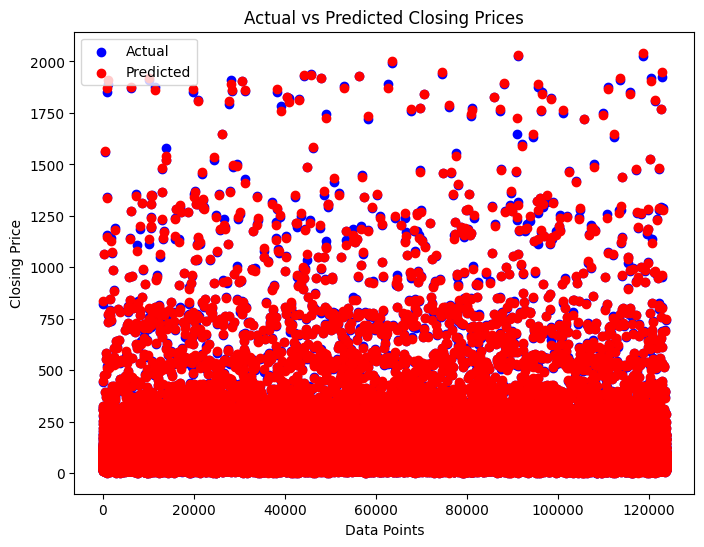

In [ ]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred_dt)), y_pred_dt, color='red', label='Predicted')
plt.title("Actual vs Predicted Closing Prices")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

## ARIMA

In [ ]:
df_copy = df
df_copy

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [ ]:
df_copy.isna().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [ ]:
df_copy['volume'] = df_copy['volume'].apply(lambda x : str(x))
df_copy['volume'] = pd.to_numeric(df_copy['volume'].apply(lambda x : x.replace(',','',1)))

df_copy['open'] = pd.to_numeric(df_copy['open'])
df_copy['close'] = pd.to_numeric(df_copy['close'])
df_copy['high'] = pd.to_numeric(df_copy['high'])
df_copy['low'] = pd.to_numeric(df_copy['low'])

<Axes: xlabel='date'>

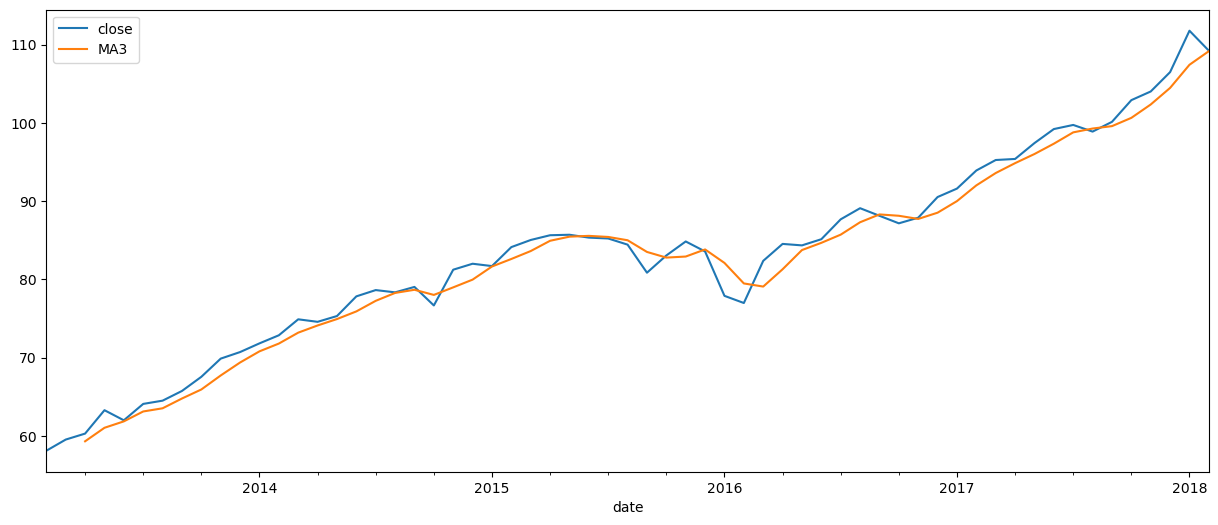

In [ ]:
y = df[['date', 'close']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Compute rolling mean with window size of 3
y['MA3'] = y.rolling(window=3).mean() 

# Plot the resulting time series
y.plot(figsize=(15,6))

<Axes: xlabel='date'>

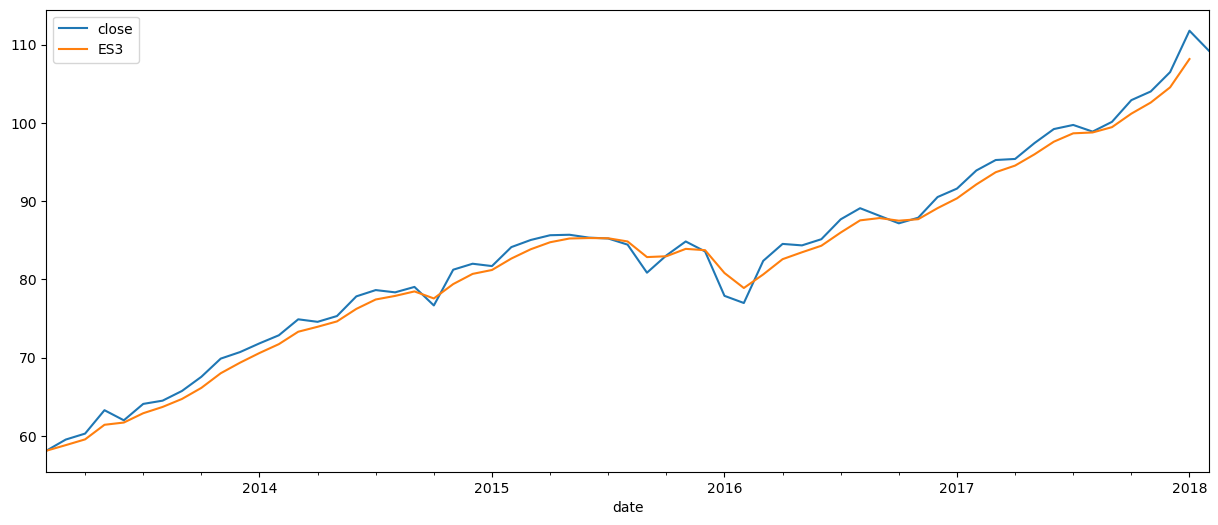

In [ ]:

# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)
y['ES3'] = SimpleExpSmoothing(y['close']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)
y[['close','ES3']].plot(figsize=(15,6))

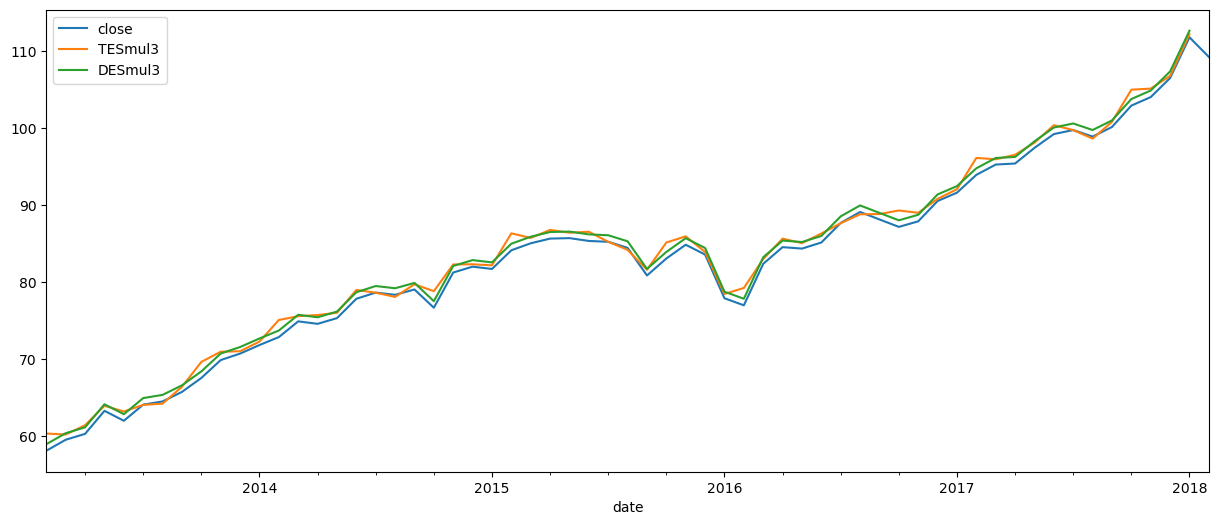

In [ ]:
y['DESmul3'] = ExponentialSmoothing(y['close'], trend='add').fit().fittedvalues.shift(-1)

y['TESmul3'] = ExponentialSmoothing(y['close'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)

y[['close', 'TESmul3', 'DESmul3']].plot(figsize=(15, 6))


df_copy = df_copy.reindex(index=df_copy.index[::-1])

In [ ]:
model = ARIMA(df_copy['close'], order=(1, 1, 2))
fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:               619040
Model:                 ARIMA(1, 1, 2)   Log Likelihood            -1849549.970
Date:                Sat, 02 Dec 2023   AIC                        3699107.940
Time:                        18:33:39   BIC                        3699153.284
Sample:                             0   HQIC                       3699120.664
                             - 619040                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5206      0.009    -59.074      0.000      -0.538      -0.503
ma.L1          0.5287      0.009     59.931      0.000       0.511       0.546
ma.L2         -0.0181      0.001    -32.281      0.0

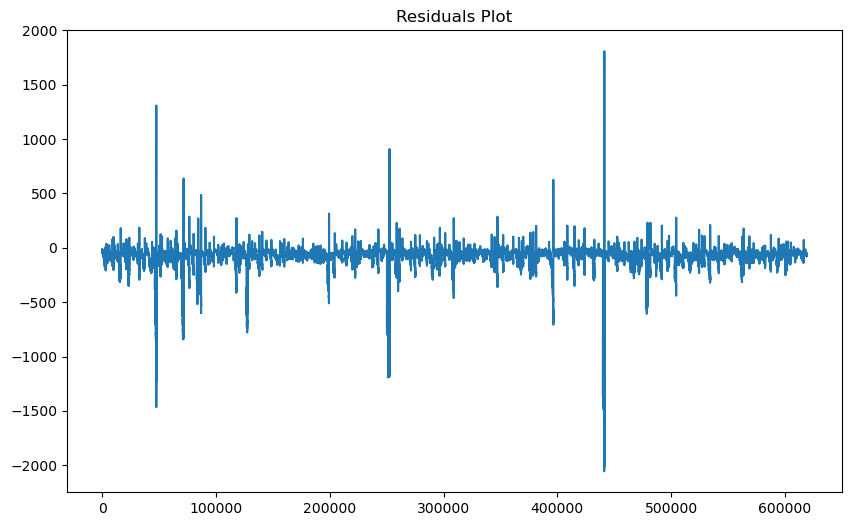

In [ ]:
fitted_values = fitted.fittedvalues
residuals = df_copy['close'].diff().dropna() - fitted_values

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals Plot')
plt.show()


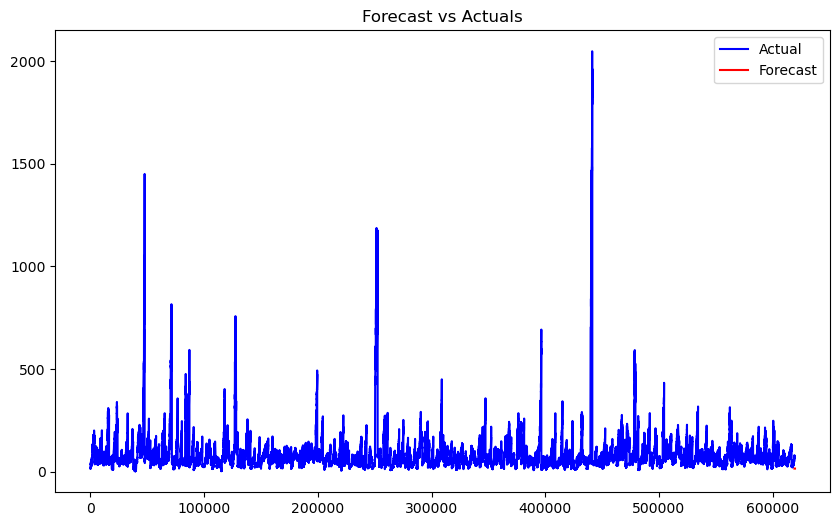

In [ ]:

forecast = fitted.forecast(steps=500)

plt.figure(figsize=(10, 6))
plt.plot(df_copy['close'], color='blue', label='Actual')  # Actual values in blue
plt.plot(range(len(df_copy['close']), len(df_copy['close']) + len(forecast)), forecast, color='red', label='Forecast')  # Forecasted values in red
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()

In [ ]:
mse_arima = mean_squared_error(df_copy['close'], fitted_values)
r2_arima = r2_score(df_copy['close'], fitted_values)

print("Ridge Regression Mean Squared Error for ARIMA Model: ", mse_arima)
print("R-squared for ARIMA Model: ", r2_arima )

Ridge Regression Mean Squared Error for ARIMA Model:  23.058994103849155
R-squared for ARIMA Model:  0.9975688342117737


In [ ]:
from sklearn.svm import SVR

# Initializing and training the SVM Regression model
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions
svm_predictions = svm_model.predict(X_test)

# Evaluate the model
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(svm_predictions)), svm_predictions, color='red', label='Predicted (SVM)')
plt.title("Actual vs Predicted Closing Prices using SVM Regression")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

print("SVM Regression Mean Squared Error: ", svm_mse)
print("R-squared for SVM Regression: ", svm_r2)

NameError: name 'X_train' is not defined